In [1]:
from datasets import load_dataset, Dataset
from tqdm.notebook import tqdm

In [2]:
vibravox = load_dataset("Cnam-LMSSC/vibravox", 'speech_clean', split='train', streaming=True)

Resolving data files:   0%|          | 0/201 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/24 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/201 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/24 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

In [3]:
N = 1_000
ds_list = list(tqdm(vibravox.take(N), total=N))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
import numpy as np
from datasets import load_dataset
from IPython.display import Audio
import matplotlib.pyplot as plt
import librosa
from scipy.signal import resample_poly

from dotenv import load_dotenv
load_dotenv(); # reads .env file

In [2]:
ds = load_dataset("Cnam-LMSSC/vibravox", "speech_clean", streaming=True, split="train")
examples = list(ds.take(100))

data = list(map(lambda x: x['audio.headset_microphone'].get_all_samples(), examples))

In [ ]:
a_48khz = data[1].data.numpy()
a_16khz = librosa.resample(a_48khz, orig_sr=48000, target_sr=16000)

In [15]:
Audio(a_48khz, rate=48000)

In [16]:
Audio(a_16khz, rate=16000)

In [ ]:

def measure_snr(signal, noise):
    """SNR in dB between a clean signal and noise array."""
    sig_power = np.mean(signal ** 2)
    noise_power = np.mean(noise ** 2)
    return 10 * np.log10(sig_power / noise_power)

def add_white_noise(signal, snr_db):
    """Add white Gaussian noise at a target SNR (dB)."""
    sig_power = np.mean(signal ** 2)
    noise_power = sig_power / (10 ** (snr_db / 10))
    noise = np.random.randn(*signal.shape).astype(signal.dtype) * np.sqrt(noise_power)
    return signal + noise, noise

def add_pink_noise(signal, snr_db):
    """Add pink (1/f) noise at a target SNR (dB). More natural than white noise."""
    N = signal.shape[-1]
    freqs = np.fft.rfftfreq(N)
    freqs[0] = 1  # avoid division by zero at DC
    pink_spectrum = np.random.randn(len(freqs)) / np.sqrt(freqs)
    pink = np.fft.irfft(pink_spectrum, n=N).astype(signal.dtype)
    # scale to desired power
    sig_power = np.mean(signal ** 2)
    noise_power = sig_power / (10 ** (snr_db / 10))
    pink = pink / np.sqrt(np.mean(pink ** 2)) * np.sqrt(noise_power)
    return signal + pink, pink

np.random.seed(42)
sig_16 = a_16khz.squeeze()

target_snr = 10  # dB — try 0, 5, 10, 20

noisy_white, noise_white = add_white_noise(sig_16, target_snr)
noisy_pink,  noise_pink  = add_pink_noise(sig_16,  target_snr)

print(f"Target SNR  : {target_snr} dB")
print(f"White noise : {measure_snr(sig_16, noise_white):.2f} dB")
print(f"Pink  noise : {measure_snr(sig_16, noise_pink):.2f} dB")


In [ ]:

print("Clean:")
display(Audio(sig_16, rate=16000))
print("White noise (10 dB SNR):")
display(Audio(noisy_white, rate=16000))
print("Pink noise (10 dB SNR):")
display(Audio(noisy_pink, rate=16000))


STFT shape: (257, 325)  (freq_bins x time_frames)
Freq bins : 257  →  0 to 8000 Hz
Time frames: 325  →  each step = 8.0 ms


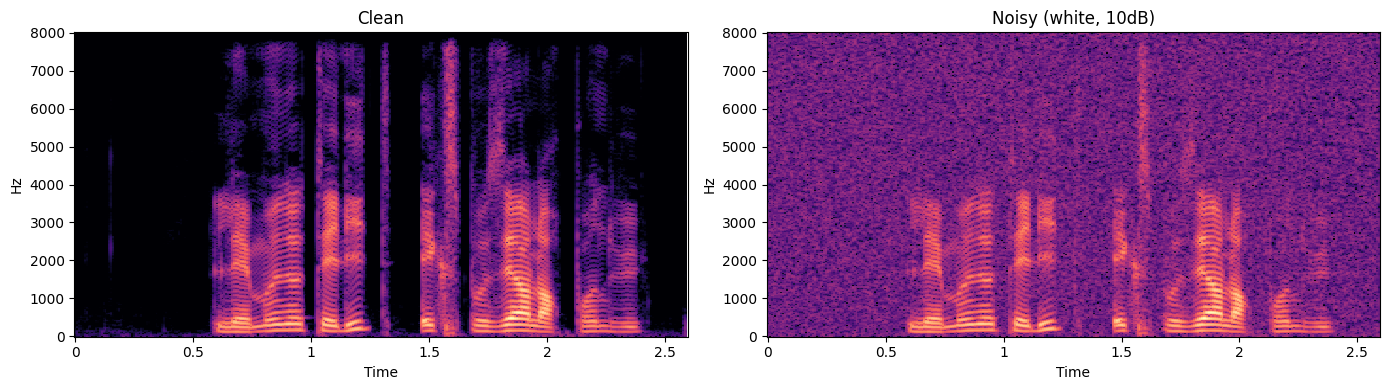

In [21]:

S_clean = librosa.stft(sig_16, n_fft=512, hop_length=128, window='hann')
S_noisy = librosa.stft(noisy_white, n_fft=512, hop_length=128, window='hann')

print(f"STFT shape: {S_clean.shape}  (freq_bins x time_frames)")
print(f"Freq bins : {S_clean.shape[0]}  →  0 to {16000//2} Hz")
print(f"Time frames: {S_clean.shape[1]}  →  each step = {128/16000*1000:.1f} ms")

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
for S, ax, label in [(S_clean, axes[0], "Clean"), (S_noisy, axes[1], "Noisy (white, 10dB)")]:
    D = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    librosa.display.specshow(D, sr=16000, hop_length=128, x_axis='time', y_axis='hz', ax=ax)
    ax.set_title(label)
plt.tight_layout()
plt.show()


32 ERB bands  |  lowest center: 66 Hz  |  highest center: 7587 Hz


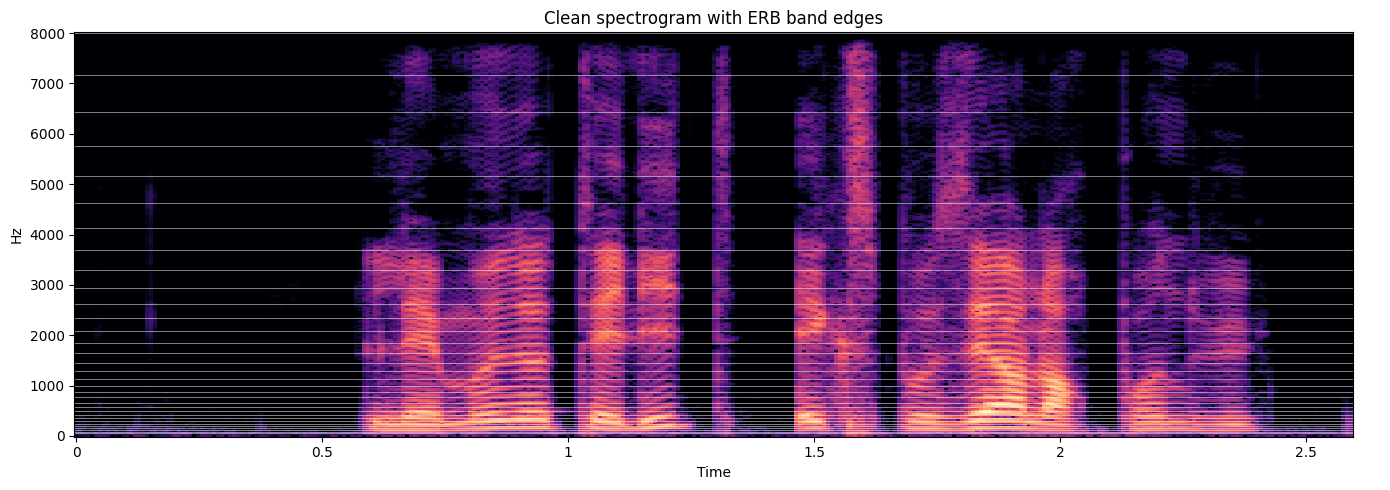

In [20]:

def hz_to_erb_rate(f):
    """Frequency in Hz → ERB-rate (number of ERBs from 0 Hz)."""
    return 21.4 * np.log10(4.37 * f / 1000 + 1)

def erb_rate_to_hz(e):
    """ERB-rate → frequency in Hz."""
    return (10 ** (e / 21.4) - 1) * 1000 / 4.37

def erb_band_edges(n_bands=32, f_min=50, f_max=8000):
    """Return (n_bands+1,) array of ERB band edge frequencies in Hz."""
    e_min, e_max = hz_to_erb_rate(f_min), hz_to_erb_rate(f_max)
    return erb_rate_to_hz(np.linspace(e_min, e_max, n_bands + 1))

SR = 16000
N_BANDS = 32
edges = erb_band_edges(N_BANDS, f_min=50, f_max=SR // 2)
centers = (edges[:-1] + edges[1:]) / 2

print(f"{N_BANDS} ERB bands  |  lowest center: {centers[0]:.0f} Hz  |  highest center: {centers[-1]:.0f} Hz")

fig, ax = plt.subplots(figsize=(14, 5))
D = librosa.amplitude_to_db(np.abs(S_clean), ref=np.max)
librosa.display.specshow(D, sr=SR, hop_length=128, x_axis='time', y_axis='hz', ax=ax)
ax.set_title("Clean spectrogram with ERB band edges")

for f in edges:
    ax.axhline(f, color='white', linewidth=0.6, alpha=0.6)

# label every 4th band center on the right
for i, f in enumerate(centers):
    if i % 4 == 0:
        ax.text(ax.get_xlim()[1] * 1.002, f, f'{f:.0f}', va='center',
                fontsize=7, color='white')

plt.tight_layout()
plt.show()


In [ ]:

import sys
sys.path.insert(0, '.')
from dsp import DSPFrontend

SR = 16000
frontend = DSPFrontend(sr=SR, frame_ms=20, hop_ms=10, n_bands=22)


In [ ]:

def wiener_enhance(noisy: np.ndarray, frontend: DSPFrontend,
                   noise_percentile: float = 15.0,
                   wiener_floor: float = 0.01,
                   voiced_boost: float = 1.2) -> np.ndarray:
    """
    Classical Wiener-filter speech enhancement using DSPFrontend features.

    Steps
    -----
    1. Extract per-frame band energies and pitch info via DSPFrontend.
    2. Estimate noise floor per band as a low percentile over all frames
       (min-statistics: noise is the quietest parts of the recording).
    3. Compute per-band Wiener gain = max(floor, 1 - noise_E / noisy_E).
    4. Optionally amplify gains on voiced frames (high pitch_corr).
    5. Map band gains → FFT bin gains via the filterbank weights.
    6. Apply gains to the frame's complex spectrum, reconstruct with OLA.
    """
    frame_size = frontend.frame_size
    hop_size   = frontend.hop_size
    n_fft      = frontend.n_fft
    window     = frontend.window
    filterbank = frontend.filterbank          # (n_bands, n_freqs)
    n_freqs    = n_fft // 2 + 1

    audio = noisy.astype(np.float64)
    n_frames = 1 + (len(audio) - frame_size) // hop_size

    # ── 1. Run DSP frontend to get per-frame features ──────────────────────
    features = frontend.process(audio)

    # band_energies matrix: (n_frames, n_bands) in dB → convert to linear
    band_energy_lin = np.array([
        10 ** (f.band_energy_db / 10) for f in features
    ])  # (n_frames, n_bands)

    pitch_corrs = np.array([f.pitch_corr for f in features])  # (n_frames,)

    # ── 2. Noise floor estimate per band ───────────────────────────────────
    # Low percentile over time ≈ "quietest the band ever is" = noise floor
    noise_floor = np.percentile(band_energy_lin, noise_percentile, axis=0)  # (n_bands,)

    # ── 3. Per-frame, per-band Wiener gains ────────────────────────────────
    # Wiener gain: G = max(floor, 1 - noise / signal)
    # Clip to [floor, 1] so we never amplify or fully null
    gains = np.clip(1.0 - noise_floor[None, :] / (band_energy_lin + 1e-12),
                    wiener_floor, 1.0)  # (n_frames, n_bands)

    # ── 4. Voiced boost ────────────────────────────────────────────────────
    # Voiced frames (high pitch_corr) → relax suppression slightly
    voicing_factor = 1.0 + (voiced_boost - 1.0) * pitch_corrs[:, None]
    gains = np.clip(gains * voicing_factor, wiener_floor, 1.0)

    # ── 5. Map band gains → FFT bin gains via filterbank ──────────────────
    # For each bin k: gain_k = Σ_b(filterbank[b,k] * G_b) / Σ_b filterbank[b,k]
    # filterbank.T @ gains[i]  gives a weighted sum over bands (n_freqs,)
    # We normalize by the sum of filterbank weights per bin
    bank_sum = filterbank.sum(axis=0)  # (n_freqs,) — how much each bin contributes
    bank_sum = np.maximum(bank_sum, 1e-8)

    bin_gains = (gains @ filterbank) / bank_sum[None, :]  # (n_frames, n_freqs)

    # ── 6. Apply gains to complex STFT frames, reconstruct via OLA ────────
    out = np.zeros(len(audio) + n_fft)
    window_sum = np.zeros_like(out)

    for i in range(n_frames):
        start = i * hop_size
        frame = audio[start:start + frame_size]

        windowed  = frame * window
        spectrum  = np.fft.rfft(windowed, n=n_fft)

        # Apply gain in frequency domain
        enhanced_spectrum = spectrum * bin_gains[i]

        # Back to time domain
        enhanced_frame = np.fft.irfft(enhanced_spectrum, n=n_fft)[:frame_size]

        # Overlap-add with Hann window (synthesis window = analysis window)
        out[start:start + frame_size] += enhanced_frame * window
        window_sum[start:start + frame_size] += window ** 2

    # Normalize by OLA window sum (avoids amplitude modulation artifacts)
    mask = window_sum > 1e-8
    out[mask] /= window_sum[mask]

    return out[:len(audio)].astype(np.float32)


enhanced = wiener_enhance(noisy_white.astype(np.float64), frontend)

print(f"Input  SNR: {measure_snr(sig_16, noise_white):.1f} dB")
print(f"Output SNR: {measure_snr(sig_16, enhanced - sig_16):.1f} dB")
print("Clean:")
display(Audio(sig_16, rate=SR))
print("Noisy (white, 10dB SNR):")
display(Audio(noisy_white, rate=SR))
print("Enhanced (DSP Wiener, no NN):")
display(Audio(enhanced, rate=SR))


In [29]:

import torch
import torch.nn as nn


# =============================================================================
# 1. ERB Layer  —  same filterbank as dsp.py, wrapped for PyTorch
# =============================================================================

class ERBLayer(nn.Module):
    """Fixed (non-learned) ERB filterbank. No parameters, just a buffer."""

    def __init__(self, sr=16000, n_fft=512, n_bands=32):
        super().__init__()
        from dsp import compute_erb_bands
        W, _ = compute_erb_bands(sr, n_fft, n_bands)         # (n_bands, n_freqs)
        self.register_buffer('W', torch.FloatTensor(W))

    def compress(self, stft):
        """(B, F, T, 2)  →  (B, n_bands, T, 2)"""
        x = stft.permute(0, 2, 3, 1)   # (B, T, 2, F)
        y = x @ self.W.T                # (B, T, 2, n_bands)
        return y.permute(0, 3, 1, 2)   # (B, n_bands, T, 2)

    def expand(self, x):
        """(B, n_bands, T, 2)  →  (B, F, T, 2)"""
        x = x.permute(0, 2, 3, 1)      # (B, T, 2, n_bands)
        y = x @ self.W                  # (B, T, 2, F)
        return y.permute(0, 3, 1, 2)   # (B, F, T, 2)


# =============================================================================
# 2. Building Blocks
# =============================================================================

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, p=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, k, padding=p),
            nn.BatchNorm2d(out_ch),
            nn.PReLU(out_ch),
        )
    def forward(self, x): return self.net(x)


class DualPathGRU(nn.Module):
    """
    Two-pass RNN on a (B, C, F, T) tensor.
      Pass 1 — intra-frame:  GRU across the frequency axis within each frame.
      Pass 2 — inter-frame:  GRU across the time axis for each frequency bin.
    Both passes use residual connections.
    """
    def __init__(self, channels):
        super().__init__()
        self.intra = nn.GRU(channels, channels, batch_first=True)
        self.inter = nn.GRU(channels, channels, batch_first=True)
        self.ln_intra = nn.LayerNorm(channels)
        self.ln_inter = nn.LayerNorm(channels)

    def forward(self, x):
        B, C, F, T = x.shape

        # --- intra-frame (frequency axis) ---
        xi = x.permute(0, 3, 2, 1).reshape(B * T, F, C)   # (B*T, F, C)
        xi, _ = self.intra(xi)
        xi = self.ln_intra(xi).reshape(B, T, F, C).permute(0, 3, 2, 1)
        x = x + xi

        # --- inter-frame (time axis) ---
        xt = x.permute(0, 2, 3, 1).reshape(B * F, T, C)   # (B*F, T, C)
        xt, _ = self.inter(xt)
        xt = self.ln_inter(xt).reshape(B, F, T, C).permute(0, 3, 1, 2)
        return x + xt


# =============================================================================
# 3. Encoders  —  air mic gets a deeper encoder; BCM gets a shallower one
# =============================================================================

class AirEncoder(nn.Module):
    """Full 4-block encoder for noisy air-mic features."""
    def __init__(self, ch=32):
        super().__init__()
        self.net = nn.Sequential(
            ConvBlock(2,      ch // 2),
            ConvBlock(ch // 2, ch // 2),
            ConvBlock(ch // 2, ch),
            ConvBlock(ch,      ch),
        )
    def forward(self, x): return self.net(x)   # (B, ch, F, T)


class BCMEncoder(nn.Module):
    """
    Lightweight 2-block encoder for the bone conduction mic.

    BCM is already clean (no airborne noise) and band-limited (~0-4 kHz),
    so its structure is much simpler than the noisy air mic → fewer blocks needed.
    Outputs the same channel dimension as AirEncoder for easy fusion.
    """
    def __init__(self, ch=32):
        super().__init__()
        self.net = nn.Sequential(
            ConvBlock(2, ch // 2),
            ConvBlock(ch // 2, ch),
        )
    def forward(self, x): return self.net(x)   # (B, ch, F, T)


# =============================================================================
# 4. Decoder
# =============================================================================

class Decoder(nn.Module):
    def __init__(self, ch=32):
        super().__init__()
        self.net = nn.Sequential(
            ConvBlock(ch,      ch),
            ConvBlock(ch,      ch // 2),
            ConvBlock(ch // 2, ch // 2),
            nn.Conv2d(ch // 2, 2, kernel_size=1),  # → (B, 2, F, T): re + im of mask
        )
    def forward(self, x): return self.net(x)


# =============================================================================
# 5. Full Dual-Input Model
# =============================================================================

class BoneCondGTCRN(nn.Module):
    """
    Dual-input speech enhancer: noisy air mic  +  bone conduction reference.

    How bone conduction helps
    -------------------------
    BCM picks up bone vibrations → captures speech but NOT airborne noise.
    It is naturally denoised but heavily low-pass (usable up to ~4 kHz).
    We encode it separately and *add* its features to the air-mic features
    before the recurrent bottleneck, giving the RNN a clean speech prior.

    Architecture
    ------------
        air_stft ──► ERB ──► AirEncoder ──► + ──► DPGRNN × 2 ──► Decoder ──► ERB⁻¹ ──► CRM ──► enhanced
        bcm_stft ──► ERB ──► BCMEncoder ──►/

    Fusion is additive at the bottleneck (zero extra parameters, BCMEncoder
    output already has the same shape as AirEncoder output).

    Parameters: ~64 K total  (+~5 K vs a single-input version)
    """

    def __init__(self, sr=16000, n_fft=512, n_bands=32, channels=32):
        super().__init__()
        self.erb     = ERBLayer(sr, n_fft, n_bands)
        self.air_enc = AirEncoder(channels)
        self.bcm_enc = BCMEncoder(channels)
        self.dp1     = DualPathGRU(channels)
        self.dp2     = DualPathGRU(channels)
        self.decoder = Decoder(channels)

    def _stft_to_input(self, stft):
        """(B, F, T, 2) → (B, 2, n_bands, T)  ready for Conv2d."""
        erb = self.erb.compress(stft)          # (B, n_bands, T, 2)
        return erb.permute(0, 3, 1, 2)         # (B, 2, n_bands, T)

    def forward(self, air_stft, bcm_stft):
        """
        air_stft : (B, F, T, 2)  –  noisy air microphone STFT
        bcm_stft : (B, F, T, 2)  –  bone conduction STFT (clean, band-limited)
        returns  : (B, F, T, 2)  –  estimated clean speech STFT
        """
        # Encode both modalities
        air_feat = self.air_enc(self._stft_to_input(air_stft))   # (B, C, F_erb, T)
        bcm_feat = self.bcm_enc(self._stft_to_input(bcm_stft))   # (B, C, F_erb, T)

        # Fusion: BCM adds clean speech evidence to the noisy air features
        fused = air_feat + bcm_feat                               # (B, C, F_erb, T)

        # Recurrent bottleneck (models freq correlations + temporal dynamics)
        z = self.dp2(self.dp1(fused))                             # (B, C, F_erb, T)

        # Decode to complex ratio mask
        mask = torch.tanh(self.decoder(z))                        # (B, 2, F_erb, T)
        mask = mask.permute(0, 2, 3, 1)                           # (B, F_erb, T, 2)
        mask = self.erb.expand(mask)                              # (B, F, T, 2)

        return air_stft * mask


In [30]:

# --- Parameter count ---
model = BoneCondGTCRN(sr=16000, n_fft=512, n_bands=32, channels=32)
total = sum(p.numel() for p in model.parameters())
by_module = {
    name: sum(p.numel() for p in mod.parameters())
    for name, mod in model.named_children()
}
print(f"Total parameters: {total:,}")
for name, count in by_module.items():
    print(f"  {name:12s}: {count:6,}")

# --- Forward pass smoke test ---
N_FFT, HOP = 512, 128
def to_stft_tensor(audio, n_fft=N_FFT, hop=HOP):
    """numpy (T,) → torch (1, F, T, 2) complex STFT tensor."""
    import librosa
    S = librosa.stft(audio.astype(np.float32), n_fft=n_fft, hop_length=hop, window='hann')
    # S: (F, T) complex  →  stack re/im  →  (1, F, T, 2)
    S_t = torch.FloatTensor(np.stack([S.real, S.imag], axis=-1)).unsqueeze(0)
    return S_t

air_t = to_stft_tensor(noisy_white)
bcm_t = torch.zeros_like(air_t)           # placeholder until real BCM loaded

with torch.no_grad():
    out = model(air_t, bcm_t)

print(f"\nInput  shape: {air_t.shape}  (B, F, T, 2)")
print(f"Output shape: {out.shape}  (B, F, T, 2)")
print("Forward pass OK")


Total parameters: 63,906
  erb         :      0
  air_enc     : 16,800
  bcm_enc     :  5,088
  dp1         : 12,800
  dp2         : 12,800
  decoder     : 16,418

Input  shape: torch.Size([1, 257, 325, 2])  (B, F, T, 2)
Output shape: torch.Size([1, 257, 325, 2])  (B, F, T, 2)
Forward pass OK


Air mic shape : (41488,)
BCM shape     : (41488,)

Clean air mic:


BCM (forehead accelerometer):


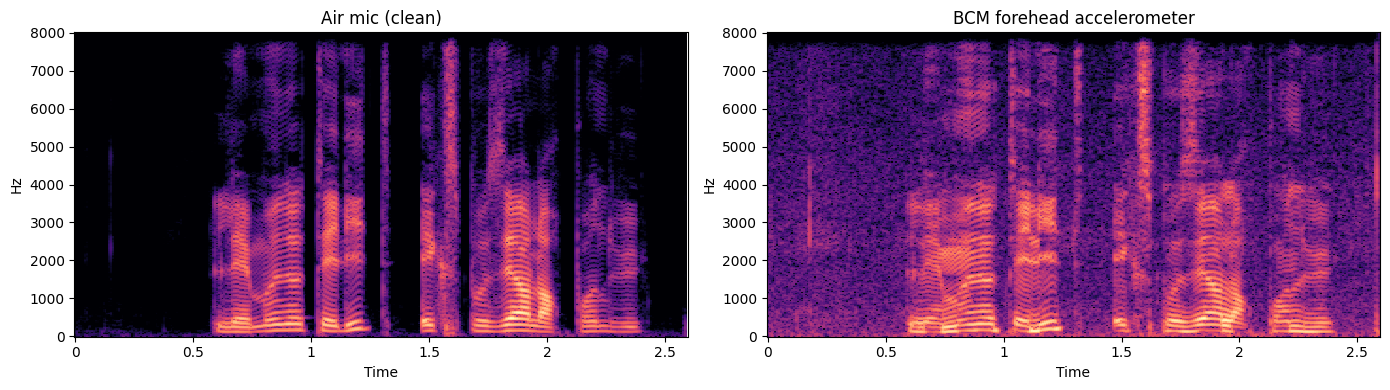

In [31]:

# --- Load BCM from Vibravox (forehead accelerometer) ---
# Vibravox has 6 synchronized channels per recording.
# We use:
#   audio.headset_microphone   → clean target  (add synthetic noise to make input)
#   audio.forehead_accelerometer → BCM input   (naturally noise-free)

ex = examples[1]   # same example used throughout the notebook

bcm_48khz = ex['audio.forehead_accelerometer'].get_all_samples().data.numpy()
bcm_16khz = librosa.resample(bcm_48khz, orig_sr=48000, target_sr=16000)
bcm_16  = bcm_16khz.squeeze()

print(f"Air mic shape : {sig_16.shape}")
print(f"BCM shape     : {bcm_16.shape}")

print("\nClean air mic:")
display(Audio(sig_16, rate=16000))
print("BCM (forehead accelerometer):")
display(Audio(bcm_16, rate=16000))

# ---- Quick spectral comparison ----
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
for sig, ax, label in [(sig_16, axes[0], "Air mic (clean)"),
                        (bcm_16,  axes[1], "BCM forehead accelerometer")]:
    S = librosa.stft(sig.astype(np.float32), n_fft=512, hop_length=128, window='hann')
    D = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    librosa.display.specshow(D, sr=16000, hop_length=128, x_axis='time', y_axis='hz', ax=ax)
    ax.set_title(label)
plt.tight_layout()
plt.show()
